# Creating Subarray Images with SPyFFI
This notebook shows some of the basics of SPyFFI, using it to create images over a small subarray of the detector. Because this is rendering fewer pixels, it's probably the fastest way to test `SPyFFI` end-to-end to make sure it's working.

In [1]:
# this sets where to look for inputs and store outputs 
# (it will default to `~/.tess/spyffi` if the $SPYFFIDATA environment variable isn't set)
import os
os.environ["SPYFFIDATA"] = '/Users/zkbt/Cosmos/Data/TESS/FFIs'

In [2]:
# this makes sure that updates are actually printed to the terminal (inside of just to a log)
import logging
logging.basicConfig(level="INFO")

In [3]:
# this loads a default observation definition, which is a dictionary of dictionaries
from spyffi.Observation import Observation, default
inputs = default

The inputs are all organized into dictionaryies within the `inputs` dictionary.

In [4]:
# how do we define the catalog of stars to use (and the light curves)
print default['catalog']

{'skykw': {'faintlimit': None, 'fast': False}, 'catalogue': 'UCAC4', 'starsarevariable': True, 'name': 'sky', 'lckw': {'fractionwithextremelc': 0.005, 'fractionofstarswithlc': 0.5, 'fractionwithcustom': 0.1, 'fractionwithrotation': 0.2, 'seed': 0, 'fainteststarwithlc': None, 'options': ['trapezoid', 'sin'], 'fractionwithtrapezoid': 0.3}, 'testpatternkw': {'randomizenudgesby': 21.1, 'randomizepropermotionsby': 0.0, 'spacing': 500.0, 'magnitudes': [10, 10], 'randomizemagnitudes': False}}


In [5]:
# how should exposures be created (what should be written out?)
print default['expose']

{'magnitudethreshold': 999, 'jitter': True, 'correctcosmics': True, 'smear': False, 'cosmicsdiffusion': True, 'compress': {120: True, 1800: False, 2: True, 20: True}, 'cosmicsversion': 'fancy', 'writecosmics': False, 'writesimulated': True, 'skipcosmics': True, 'writenoiseless': False, 'display': False}


In [6]:
# set up the geometry of the camera, and (importantly) the PSF library
print default['camera']

{'psfkw': {'nsubpixelsperpixel': 101, 'focus_toinclude': [0, 10], 'npixels': 21, 'noffsets_toinclude': 11, 'npositions_toinclude': 11, 'version': 'RRUasbuilt', 'stellartemp_toinclude': [4350], 'debprefix': 'woods_prf_feb2016/RAYS_ptSrc_wSi_Oct27model_AP40.6_75C_F3p314adj'}, 'focuskw': {'span': [0.0, 10.0]}, 'positionangle': 0.0, 'label': 'testing', 'jitterkw': {'amplifyinterexposurejitter': 1.0, 'rawjitterbasename': 'cartoon.jitter', 'jitterrms': None}, 'stamps': {120: None, 1800: None, 2: None, 20: None}, 'variablefocus': True, 'counterstep': 1, 'warpspaceandtime': False, 'subarray': None, 'dec': 66.56070833333332, 'roll': 0, 'cadence': 1800, 'ra': 270.0}


In [7]:
# in what ways should we jitter the motion of the camera?
print default['jitter']

{'amplifyinterexposurejitter': 1.0, 'rawjitterbasename': 'cartoon.jitter', 'jitterrms': None}


In [8]:
# how many of each exposure time should we create (and in what order?)
print default['observation']

{'cadencestodo': {120: 3, 1800: 3, 2: 3, 20: 3}, 'collate': True}


Let's modify some of those input options, by changing values associated with some of the directory keys inside each sub-group.

In [9]:
# give a label to this observation (that goes into the directory name)
inputs['camera']['label'] = 'transit'
# how big of a subarray in pixels (centered on the FOV); None will give four normal CCDs
inputs['camera']['subarray'] = 200
# should we change the focus throughout the orbit? 
inputs['camera']['variablefocus'] = False

# should we skip injecting cosmic rays? (False = *do* inject cosmics)
inputs['expose']['skipcosmics'] = False
# let's write the cosmic ray images out as separate files
inputs['expose']['writecosmics'] = True

# what's the catalog ("testpattern" or "UCAC4")
inputs['catalog']['name'] = 'testpattern'
# should we randomize the magnitudes of the stars
inputs['catalog']['testpatternkw']['randomizemagnitudes'] = True
# what range of magnitudes should the stars span?
inputs['catalog']['testpatternkw']['magnitudes'] = [6,16]

# how many of each exposure duration should we make?
inputs['observation']['cadencestodo'] = {1800:100}
o = Observation(inputs)

INFO:spyffi.Observation:  creating a new observation, with the following inputs:
INFO:spyffi.Observation:      inputs[expose] = 
INFO:spyffi.Observation:                 magnitudethreshold:999
INFO:spyffi.Observation:                             jitter:True
INFO:spyffi.Observation:                     correctcosmics:True
INFO:spyffi.Observation:                              smear:False
INFO:spyffi.Observation:                   cosmicsdiffusion:True
INFO:spyffi.Observation:                           compress:{120: True, 1800: False, 2: True, 20: True}
INFO:spyffi.Observation:                     cosmicsversion:fancy
INFO:spyffi.Observation:                       writecosmics:True
INFO:spyffi.Observation:                     writesimulated:True
INFO:spyffi.Observation:                        skipcosmics:False
INFO:spyffi.Observation:                     writenoiseless:False
INFO:spyffi.Observation:                            display:False
INFO:spyffi.Observation:      inputs[camera] = 


In [10]:
# generate some light curves to populate the catalog
import spyffi.Lightcurve as lc, numpy as np

# every star in the catalog has a light curve; we can modify them one-by-one
for i in range(len(o.camera.catalog.ra)):
    o.camera.catalog.lightcurves[i] = lc.constant()

# we can convert the catalog RA + Dec to x, y
ra, dec = o.camera.catalog.ra, o.camera.catalog.dec
coord = o.camera.cartographer.point(ra, dec, 'celestial')
x, y = coord.ccdxy.tuple

# let's pick one bright star that's on the detector...
n = o.camera.ccds[0].xsize
ok = (x > 0)*(x < n)*(y < n)*(y > 0)
ok *= (o.camera.catalog.tmag < 11.0)
lucky = np.random.choice(np.nonzero(ok)[0], 1)[0]

# ... and inject a deep transit into it
o.camera.catalog.lightcurves[lucky] = lc.Trapezoid(P=0.3, 
                                                   E=2457827.0 + 0.15, 
                                                   D=1.0, 
                                                   T23=0.00, 
                                                   T14=0.1)

In [11]:
# let's print out the locations and light curves of the stars
for i, l in enumerate(o.camera.catalog.lightcurves):
    print '{:>5} = ({:5.1f},{:5.1f}) = {}'.format(i,x[i],y[i],l)

    0 = (289.1,-86.3) = <constant()>
    1 = (265.4,-86.8) = <constant()>
    2 = (241.8,-87.6) = <constant()>
    3 = (218.0,-88.9) = <constant()>
    4 = (194.4,-89.1) = <constant()>
    5 = (170.6,-89.9) = <constant()>
    6 = (146.9,-90.3) = <constant()>
    7 = (123.2,-90.3) = <constant()>
    8 = ( 99.5,-90.5) = <constant()>
    9 = ( 75.8,-90.5) = <constant()>
   10 = ( 52.1,-90.1) = <constant()>
   11 = ( 28.5,-89.1) = <constant()>
   12 = (  4.6,-89.3) = <constant()>
   13 = (-19.0,-88.7) = <constant()>
   14 = (-42.6,-88.2) = <constant()>
   15 = (-66.4,-86.9) = <constant()>
   16 = (-90.0,-86.2) = <constant()>
   17 = (289.1,-61.9) = <constant()>
   18 = (265.4,-63.4) = <constant()>
   19 = (241.7,-63.6) = <constant()>
   20 = (218.0,-64.5) = <constant()>
   21 = (194.3,-65.0) = <constant()>
   22 = (170.6,-66.0) = <constant()>
   23 = (147.0,-66.1) = <constant()>
   24 = (123.3,-66.2) = <constant()>
   25 = ( 99.5,-66.7) = <constant()>
   26 = ( 75.9,-65.9) = <constant()>
 

<Trapezoid(T14=0.1,P=0.3,T23=0.0,E=2457827.15,D=1.0)>


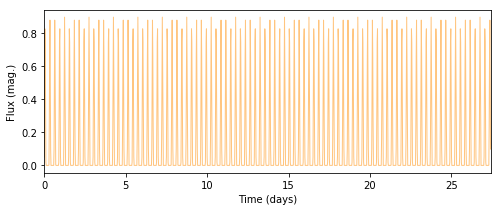

In [12]:
# let's plot the light curve of that one lucky star
%matplotlib inline 
l = o.camera.catalog.lightcurves[lucky]
l.demo()
print l

INFO:spyffi.Camera:setting cadence to 1800 seconds = 900 reads.
INFO:spyffi.Jitter:populating the jitterball for 1800 second cadence, based on the raw jitter file cartoon.jitter.cadence1800s.unscaled.
INFO:spyffi.PSF:initializing PSF painter, based on woods_prf_feb2016/RAYS_ptSrc_wSi_Oct27model_AP40.6_75C_F3p314adj
INFO:spyffi.Intrapixel:creating an intrapixel sensitivity map called perfectpixels
INFO:spyffi.PSF:setting up the pixel arrays
INFO:spyffi.PSF:created pixel coordinate arrays
INFO:spyffi.CCD:created CCD #1, of size 21x21
INFO:spyffi.PSF:trying to load PSFs from /Users/zkbt/Cosmos/Data/TESS/FFIs/intermediates/psfs/RRUasbuilt/focus0and10_stellartemp4350/pixelizedlibrary_cartoon.jitter.cadence1800s.unscaled_perfectpixels_11positions_11offsets.npy
INFO:spyffi.PSF:...success!
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.Catalogs:save projected star catalog /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/cat

INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 900 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 3 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/simulated_testpattern_6to16_sub200x200_000003.fits
INFO:spyffi.CCD:created image #0000003 of testpattern with 1800s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.0492249634949,-0.000576312617288 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.08333 = 2017.20077572
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD

INFO:spyffi.CCD:created image #0000008 of testpattern with 1800s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.0358545216741,-0.0139823504973 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.1875 = 2017.20106092
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 81 stars between 6.3 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/cosmics_testpattern_6to16_sub200x200_000009.fits
INFO:spyffi.CCD:bleeding saturated pix

INFO:spyffi.CCD:adding 81 stars between 6.3 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/cosmics_testpattern_6to16_sub200x200_000014.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 900 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 14 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/

INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 900 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 19 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/simulated_testpattern_6to16_sub200x200_000019.fits
INFO:spyffi.CCD:created image #0000019 of testpattern with 1800s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.00652791537221,-0.0114993803002 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.41667 = 2017.20168834
INFO:spyffi.Catalogs:projecting catalog -0.798 years relative to 2018
INFO:spyffi.CC

INFO:spyffi.CCD:created image #0000024 of testpattern with 1800s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.00327331926988,0.00519875631108 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.52083 = 2017.20197353
INFO:spyffi.Catalogs:projecting catalog -0.798 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 81 stars between 6.3 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/cosmics_testpattern_6to16_sub200x200_000025.fits
INFO:spyffi.CCD:bleeding saturated p

INFO:spyffi.CCD:adding 81 stars between 6.3 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/cosmics_testpattern_6to16_sub200x200_000030.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 900 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 30 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/

INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 900 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 35 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/simulated_testpattern_6to16_sub200x200_000035.fits
INFO:spyffi.CCD:created image #0000035 of testpattern with 1800s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.0295393986081,0.0103750307494 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.75 = 2017.20260096
INFO:spyffi.Catalogs:projecting catalog -0.797 years relative to 2018
INFO:spyffi.CCD:  do

INFO:spyffi.CCD:created image #0000040 of testpattern with 1800s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.026872645492,0.00591493740373 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.85417 = 2017.20288615
INFO:spyffi.Catalogs:projecting catalog -0.797 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 81 stars between 6.3 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/cosmics_testpattern_6to16_sub200x200_000041.fits
INFO:spyffi.CCD:bleeding saturated pix

INFO:spyffi.CCD:adding 81 stars between 6.3 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/cosmics_testpattern_6to16_sub200x200_000046.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 900 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 46 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/

INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 900 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 51 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/simulated_testpattern_6to16_sub200x200_000051.fits
INFO:spyffi.CCD:created image #0000051 of testpattern with 1800s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.0157719398203,-0.041062809769 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457828.08333 = 2017.20351358
INFO:spyffi.Catalogs:projecting catalog -0.796 years relative to 2018
INFO:spyffi.CCD:

INFO:spyffi.CCD:created image #0000056 of testpattern with 1800s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.0529645910017,0.0317461720954 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457828.1875 = 2017.20379877
INFO:spyffi.Catalogs:projecting catalog -0.796 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 81 stars between 6.3 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/cosmics_testpattern_6to16_sub200x200_000057.fits
INFO:spyffi.CCD:bleeding saturated pixe

INFO:spyffi.CCD:adding 81 stars between 6.3 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/cosmics_testpattern_6to16_sub200x200_000062.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 900 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 62 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/

INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 900 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 67 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/simulated_testpattern_6to16_sub200x200_000067.fits
INFO:spyffi.CCD:created image #0000067 of testpattern with 1800s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.0484985603911,-0.0198004631329 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457828.41667 = 2017.20442619
INFO:spyffi.Catalogs:projecting catalog -0.796 years relative to 2018
INFO:spyffi.CCD:

INFO:spyffi.CCD:created image #0000072 of testpattern with 1800s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.0218829180849,-0.090791393366 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457828.52083 = 2017.20471138
INFO:spyffi.Catalogs:projecting catalog -0.795 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 81 stars between 6.3 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/cosmics_testpattern_6to16_sub200x200_000073.fits
INFO:spyffi.CCD:bleeding saturated pi

INFO:spyffi.CCD:adding 81 stars between 6.3 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/cosmics_testpattern_6to16_sub200x200_000078.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 900 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 78 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/

INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 900 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 83 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/simulated_testpattern_6to16_sub200x200_000083.fits
INFO:spyffi.CCD:created image #0000083 of testpattern with 1800s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.0911951766413,-0.0283455295671 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457828.75 = 2017.20533881
INFO:spyffi.Catalogs:projecting catalog -0.795 years relative to 2018
INFO:spyffi.CCD:  d

INFO:spyffi.CCD:created image #0000088 of testpattern with 1800s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.0492689241428,-0.00888014509453 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457828.85417 = 2017.205624
INFO:spyffi.Catalogs:projecting catalog -0.794 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 81 stars between 6.3 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/cosmics_testpattern_6to16_sub200x200_000089.fits
INFO:spyffi.CCD:bleeding saturated pi

INFO:spyffi.CCD:adding 81 stars between 6.3 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/cosmics_testpattern_6to16_sub200x200_000094.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 900 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 94 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/

INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 900 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 99 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/1800s/sub200x200/simulated_testpattern_6to16_sub200x200_000099.fits
INFO:spyffi.CCD:created image #0000099 of testpattern with 1800s cadence


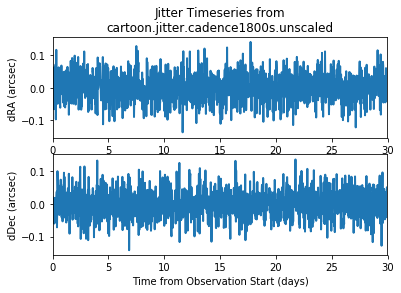

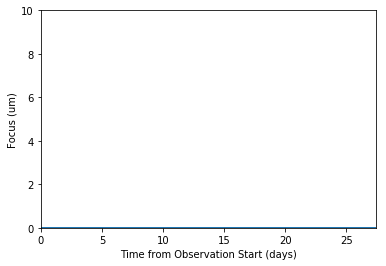

In [13]:
o.create()

This should now take a while (like a few minutes?) to create a bunch of images and drop them in `$SPYFFIDATA/testpattern_6to16_transit/1800s/sub200x200/`. Go check them out and see what's what!